<a href="https://colab.research.google.com/github/fernandoGitHub/ML_Projects/blob/main/Deep_Neural_Networks_Basic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deep Learning Library

This is a Deep Learning package I created adapted to my needs (based on the packages provided as exercise in Coursera's Deep Learning Specialization)
I will use it as a baseline when learning TensorFlow and Keras

<a name='1'></a>
## 1 - Packages

In [1]:
!pip install -Uqq ipdb
import ipdb
%pdb on

Automatic pdb calling has been turned ON


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import sklearn.datasets

#from public_tests import *

%matplotlib inline
plt.rcParams['figure.figsize'] = (7.0, 4.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

%load_ext autoreload
%autoreload 2


In [3]:
def plot_2D_decision_boundary(model, X, Y):
    # Set min and max values and give it some padding
    x_min, x_max = X[0, :].min() - 1, X[0, :].max() + 1
    y_min, y_max = X[1, :].min() - 1, X[1, :].max() + 1
    h = 0.01
    # Generate a grid of points with distance h between them
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    # Predict the function value for the whole grid
    Z = model(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    # Plot the contour and training examples
    plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral)
    plt.ylabel('x2')
    plt.xlabel('x1')
    plt.scatter(X[0, :], X[1, :], c=y, cmap=plt.cm.Spectral)
    plt.show()


def load_dataset(dataset='circles', n_train_samples=300, n_test_samples=100, train_noise=.05, test_noise=.05):
    if dataset != 'circles':
      return None, None, None, None

    train_X, train_Y = sklearn.datasets.make_circles(n_samples=n_train_samples, noise=train_noise)
    test_X, test_Y = sklearn.datasets.make_circles(n_samples=n_test_samples, noise=test_noise)
    # Visualize the data
    plt.scatter(train_X[:, 0], train_X[:, 1], c=train_Y, s=40, cmap=plt.cm.Spectral);
    train_X = train_X.T
    train_Y = train_Y.reshape((1, train_Y.shape[0]))
    test_X = test_X.T
    test_Y = test_Y.reshape((1, test_Y.shape[0]))
    return train_X, train_Y, test_X, test_Y

## 2 - NN Functions

In [4]:
#@title
def sigmoid(Z):
  """
  Implements the sigmoid activation in numpy
  Arguments:
  Z -- numpy array of any shape
  Returns:
  A -- output of sigmoid(z), same shape as Z
  cache -- returns Z as well, useful during backpropagation
  """
  A = 1/(1+np.exp(-Z))
  cache = Z
  return A, cache


def relu(Z):
  """
  Implement the RELU function.
  Arguments:
  Z -- Output of the linear layer, of any shape
  Returns:
  A -- Post-activation parameter, of the same shape as Z
  cache -- a python dictionary containing "A" ; stored for computing the backward pass efficiently
  """  
  A = np.maximum(0,Z)
  assert(A.shape == Z.shape)
  cache = Z 
  return A, cache


def relu_backward(dA, cache):
  """
  Implement the backward propagation for a single RELU unit.
  Arguments:
  dA -- post-activation gradient, of any shape
  cache -- 'Z' where we store for computing backward propagation efficiently
  Returns:
  dZ -- Gradient of the cost with respect to Z
  """
  Z = cache
  dZ = np.array(dA, copy=True) # just converting dz to a correct object.

  # When z <= 0, you should set dz to 0 as well. 
  dZ[Z <= 0] = 0
  
  assert (dZ.shape == Z.shape)
  return dZ


def sigmoid_backward(dA, cache):
  """
  Implement the backward propagation for a single SIGMOID unit.
  Arguments:
  dA -- post-activation gradient, of any shape
  cache -- 'Z' where we store for computing backward propagation efficiently
  Returns:
  dZ -- Gradient of the cost with respect to Z
  """
  Z = cache
  s = 1/(1+np.exp(-Z))
  dZ = dA * s * (1-s)
  
  assert (dZ.shape == Z.shape)
  return dZ


def initialize_NN_parameters(layer_def):
  """
  Arguments:
  layers_def -- python array (list) containing a tuple for each layer (dim, activation_fn)
  Returns:
  parameters -- python dictionary containing your parameters "W1", "b1", ..., "WL", "bL":
                  Wl -- weight matrix of shape (layer_dims[l], layer_dims[l-1])
                  bl -- bias vector of shape (layer_dims[l], 1)
                  Act_fnl - the activation function name (e.g., "sigmoid", "relu", etc.) of type str
                  L -- the number of layers in the NN
  """
  parameters = {}
  L = len(layer_def)
  parameters['L'] = L  

  for l in range(1, L):
    parameters['W' + str(l)] = np.random.randn(layer_def[l][0], layer_def[l-1][0]) / np.sqrt(layer_def[l-1][0]) 
    parameters['b' + str(l)] = np.zeros((layer_def[l][0], 1))
    parameters['Act_fn' + str(l)] = layer_def[l][1]
    
    assert(parameters['W' + str(l)].shape == (layer_def[l][0], layer_def[l-1][0]))
    assert(parameters['b' + str(l)].shape == (layer_def[l][0], 1))
      
  return parameters


def linear_forward(A, W, b):
  """
  Implement the linear part of a layer's forward propagation.
  Arguments:
  A -- activations from previous layer (or input data): (size of previous layer, number of examples)
  W -- weights matrix: numpy array of shape (size of current layer, size of previous layer)
  b -- bias vector, numpy array of shape (size of the current layer, 1)
  Returns:
  Z -- the input of the activation function, also called pre-activation parameter 
  cache -- a python dictionary containing "A", "W" and "b" ; stored for computing the backward pass efficiently
  """
  Z = W.dot(A) + b
  assert(Z.shape == (W.shape[0], A.shape[1]))
  cache = (A, W, b)
  
  return Z, cache


def linear_activation_forward(A_prev, W, b, activation):
  """
  Implement the forward propagation for the LINEAR->ACTIVATION layer
  Arguments:
  A_prev -- activations from previous layer (or input data): (size of previous layer, number of examples)
  W -- weights matrix: numpy array of shape (size of current layer, size of previous layer)
  b -- bias vector, numpy array of shape (size of the current layer, 1)
  activation -- the activation to be used in this layer, stored as a text string: "sigmoid" or "relu"
  Returns:
  A -- the output of the activation function, also called the post-activation value 
  cache -- a python dictionary containing "linear_cache" and "activation_cache";
            stored for computing the backward pass efficiently
  """
  if activation == "sigmoid":
      # Inputs: "A_prev, W, b". Outputs: "A, activation_cache".
      Z, linear_cache = linear_forward(A_prev, W, b)
      A, activation_cache = sigmoid(Z)
  
  elif activation == "relu":
      # Inputs: "A_prev, W, b". Outputs: "A, activation_cache".
      Z, linear_cache = linear_forward(A_prev, W, b)
      A, activation_cache = relu(Z)
  
  assert (A.shape == (W.shape[0], A_prev.shape[1]))
  cache = (linear_cache, activation_cache)

  return A, cache


def L_model_forward(X, parameters):
  """
  Implements forward propagation
  Arguments:
  X -- data, numpy array of shape (input size, number of examples)
  parameters -- output of initialize_NN_parameters()
  Returns:
  AL -- last post-activation value
  caches -- list of caches containing:
              every cache of linear_relu_forward() (there are L-1 of them, indexed from 0 to L-2)
              the cache of linear_activation_forward() (there is one, indexed L-1)
  """
  caches = []
  A = X
  L = parameters['L']

  for l in range(1, L-1):
    A_prev = A 
    A, cache = linear_activation_forward(A_prev, parameters['W' + str(l)], parameters['b' + str(l)], activation = parameters['Act_fn' + str(l)])
    caches.append(cache)

  AL, cache = linear_activation_forward(A, parameters['W' + str(L-1)], parameters['b' + str(L-1)], activation = parameters['Act_fn' + str(L-1)])
  caches.append(cache)
  
  assert(AL.shape == (1,X.shape[1]))     
  return AL, caches


def compute_cost(AL, Y):
  """
  Implement the cost function defined by equation (7).
  Arguments:
  AL -- probability vector corresponding to your label predictions, shape (1, number of examples)
  Y -- true "label" vector (for example: containing 0 if non-cat, 1 if cat), shape (1, number of examples)
  Returns:
  cost -- cross-entropy cost
  """
  m = Y.shape[1]

  # Compute loss from aL and y.
  cost = (1./m) * (-np.dot(Y,np.log(AL).T) - np.dot(1-Y, np.log(1-AL).T))
  cost = np.squeeze(cost)      # To make sure your cost's shape is what we expect (e.g. this turns [[17]] into 17).
  
  assert(cost.shape == ())
  return cost



def linear_backward(dZ, cache):
  """
  Implement the linear portion of backward propagation for a single layer (layer l)
  Arguments:
  dZ -- Gradient of the cost with respect to the linear output (of current layer l)
  cache -- tuple of values (A_prev, W, b) coming from the forward propagation in the current layer
  Returns:
  dA_prev -- Gradient of the cost with respect to the activation (of the previous layer l-1), same shape as A_prev
  dW -- Gradient of the cost with respect to W (current layer l), same shape as W
  db -- Gradient of the cost with respect to b (current layer l), same shape as b
  """
  A_prev, W, b = cache
  m = A_prev.shape[1]
  dW = 1./m * np.dot(dZ,A_prev.T)
  db = 1./m * np.sum(dZ, axis = 1, keepdims = True)
  dA_prev = np.dot(W.T,dZ)
  
  assert (dA_prev.shape == A_prev.shape)
  assert (dW.shape == W.shape)
  assert (db.shape == b.shape)
  return dA_prev, dW, db



def linear_activation_backward(dA, cache, activation):
  """
  Implement the backward propagation for the LINEAR->ACTIVATION layer.
  Arguments:
  dA -- post-activation gradient for current layer l 
  cache -- tuple of values (linear_cache, activation_cache) we store for computing backward propagation efficiently
  activation -- the activation to be used in this layer, stored as a text string: "sigmoid" or "relu"
  Returns:
  dA_prev -- Gradient of the cost with respect to the activation (of the previous layer l-1), same shape as A_prev
  dW -- Gradient of the cost with respect to W (current layer l), same shape as W
  db -- Gradient of the cost with respect to b (current layer l), same shape as b
  """
  linear_cache, activation_cache = cache

  if activation == "relu":
      dZ = relu_backward(dA, activation_cache)
      dA_prev, dW, db = linear_backward(dZ, linear_cache)
      
  elif activation == "sigmoid":
      dZ = sigmoid_backward(dA, activation_cache)
      dA_prev, dW, db = linear_backward(dZ, linear_cache)
  
  return dA_prev, dW, db



def L_model_backward(AL, Y, caches):
  """
  Implement the backward propagation for the [LINEAR->RELU] * (L-1) -> LINEAR -> SIGMOID group
  Arguments:
  AL -- probability vector, output of the forward propagation (L_model_forward())
  Y -- true "label" vector (containing 0 if non-cat, 1 if cat)
  caches -- list of caches containing:
              every cache of linear_activation_forward() with "relu" (there are (L-1) or them, indexes from 0 to L-2)
              the cache of linear_activation_forward() with "sigmoid" (there is one, index L-1)
  Returns:
  grads -- A dictionary with the gradients
            grads["dA" + str(l)] = ... 
            grads["dW" + str(l)] = ...
            grads["db" + str(l)] = ... 
  """
  grads = {}
  L = len(caches) # the number of layers
  m = AL.shape[1]
  Y = Y.reshape(AL.shape) # after this line, Y is the same shape as AL
  
  # Initializing the backpropagation
  dAL = - (np.divide(Y, AL) - np.divide(1 - Y, 1 - AL))
  
  # Lth layer (SIGMOID -> LINEAR) gradients. Inputs: "AL, Y, caches". Outputs: "grads["dAL"], grads["dWL"], grads["dbL"]
  current_cache = caches[L-1]
  grads["dA" + str(L-1)], grads["dW" + str(L)], grads["db" + str(L)] = linear_activation_backward(dAL, current_cache, activation = "sigmoid")
  
  for l in reversed(range(L-1)):
    # lth layer: (RELU -> LINEAR) gradients.
    current_cache = caches[l]
    dA_prev_temp, dW_temp, db_temp = linear_activation_backward(grads["dA" + str(l + 1)], current_cache, activation = "relu")
    grads["dA" + str(l)] = dA_prev_temp
    grads["dW" + str(l + 1)] = dW_temp
    grads["db" + str(l + 1)] = db_temp

  return grads



def update_parameters(parameters, grads, learning_rate):
  """
  Update parameters using gradient descent
  Arguments:
  parameters -- python dictionary containing your parameters 
  grads -- python dictionary containing your gradients, output of L_model_backward
  Returns:
  parameters -- updated
  """
  L = parameters['L']

  # Update rule for each parameter. Use a for loop.
  for l in range(1, L):
      parameters["W" + str(l)] = parameters["W" + str(l)] - learning_rate * grads["dW" + str(l)]
      parameters["b" + str(l)] = parameters["b" + str(l)] - learning_rate * grads["db" + str(l)]
      
  return parameters



def predict(X, y, parameters):
  """
  This function is used to predict the results of a  L-layer neural network.
  Arguments:
  X -- data set of examples you would like to label
  parameters -- parameters of the trained model
  Returns:
  p -- predictions for the given dataset X
  """
  m = X.shape[1]
  n = len(parameters) // 2 # number of layers in the neural network
  p = np.zeros((1,m))
  
  # Forward propagation
  probas, caches = L_model_forward(X, parameters)

  # convert probas to 0/1 predictions
  for i in range(0, probas.shape[1]):
      if probas[0,i] > 0.5:
          p[0,i] = 1
      else:
          p[0,i] = 0
  
  print("Accuracy: "  + str(np.sum((p == y)/m)))
      
  return p

In [5]:
#@title
def train_NN_model(X, Y, layers_def, learning_rate = 0.0075, num_iterations = 3000, print_cost=False):
  """
  Implements a L-layer neural network
  Arguments:
  X -- data, numpy array of shape (num_px * num_px * 3, number of examples)
  Y -- true "label" vector (containing 0 if cat, 1 if non-cat), of shape (1, number of examples)
  layers_def -- list containing the input size and activation function, of length (number of layers + 1).
  learning_rate -- learning rate of the gradient descent update rule
  num_iterations -- number of iterations of the optimization loop
  print_cost -- if True, it prints the cost every 100 steps
  
  Returns:
  parameters -- parameters learnt by the model. They can then be used to predict.
  """
  costs = []                         
  parameters = initialize_NN_parameters(layers_def)
  print_interval = int(num_iterations / 20)
  
  # Loop (gradient descent)
  for i in range(0, num_iterations):
    AL, caches = L_model_forward(X=X, parameters=parameters)
    cost = compute_cost(AL=AL, Y=Y)
    grads = L_model_backward(AL=AL, Y=Y, caches=caches)
    parameters = update_parameters(parameters=parameters, grads=grads, learning_rate=learning_rate)
            
    # Print the cost every 100 iterations
    if print_cost and i % print_interval == 0 or i == num_iterations - 1:
        print("Cost after iteration {}: {}".format(i, np.squeeze(cost)))
    if i % 100 == 0 or i == num_iterations:
        costs.append(cost)
    
  return parameters, costs


def build_model(learning_rate = 0.01, num_iterations = 1000):
  model = {}
  model['learning_rate'] = learning_rate
  model['num_iterations'] = num_iterations

  return model


In [10]:
class DeepNeuralNetwork():

  def __init__(self):
    # Define default values
    self._W = []                    # Array of weights - e.g., W1, W2, W3, ... WL+1
    self._b = []                    # Array of biases - e.g., b1, b2, b3, ..., bL+1
    self._layers_size = [0]         # Array of layers' size (includes input and output)
    self._activations_fn = [None]   # Array of activation functions for all the layers (None for the input layer)    

  def infer_input_layer(self, X):
    # Assert list is empty
    features = X.shape[0]
    self._layers_size[0] = features
    print(f'Model - added input layer \t\t Size = {features}')

  def add_hidden_layer(self, num_units=5, activation_fn='relu'):
    self._layers_size.append(num_units)
    self._activations_fn.append(activation_fn)
    print(f'Model - added hidden layer no: {len(self._layers_size)-1} \t Size = {num_units} \t Activation function = {activation_fn}')

  def add_output_layer(self, num_outputs=1, activation_fn='sigmoid'):
    # Assert list has input and at least one hidden layer
    self._layers_size.append(num_outputs)
    self._activations_fn.append(activation_fn)
    print(f'Model - Added output layer \t\t Size = {num_outputs} \t Activation function = {activation_fn}')

  def _get_deep(self):
    return len(self._layers_size)

  def _initialize(self):
    L = self._get_deep()
    self._W = [None] * (L)
    self._b = [None] * (L)

    # Index 0 is used by the input layer
    # We need to include the output layer
    for l in range(1, L):                 
      curr = self._layers_size[l]
      prev = self._layers_size[l-1]
      self._W[l] = np.random.randn(curr, prev) * np.sqrt(2/prev) 
      self._b[l] = np.zeros((curr, 1))
      assert(self._W[l].shape == (curr, prev))
      assert(self._b[l].shape == (curr, 1))
    


  def _sigmoid(self, Z):
    A = 1/(1+np.exp(-Z))
    cache = Z
    return A, cache


  def _relu(self, Z):
    A = np.maximum(0,Z)
    assert(A.shape == Z.shape)
    cache = Z 
    return A, cache


  def _relu_backward(self, dA, cache):
    Z = cache
    dZ = np.array(dA, copy=True) # just converting dz to a correct object.
    # When z <= 0, you should set dz to 0 as well. 
    #ipdb.set_trace(6)
    dZ[Z <= 0] = 0  
    assert (dZ.shape == Z.shape)
    return dZ


  def _sigmoid_backward(self, dA, cache):
    Z = cache
    s = 1/(1+np.exp(-Z))
    dZ = dA * s * (1-s)
    assert (dZ.shape == Z.shape)
    return dZ


  def _linear_forward(self, A, W, b):
    Z = W.dot(A) + b
    assert(Z.shape == (W.shape[0], A.shape[1]))
    cache = (A, W, b)
    return Z, cache


  def _linear_activation_forward(self, A_prev, W, b, activation):
    Z, linear_cache = self._linear_forward(A_prev, W, b)
    if activation == "sigmoid":
        A, activation_cache = self._sigmoid(Z)
    elif activation == "relu":
        A, activation_cache = self._relu(Z)   
    assert (A.shape == (W.shape[0], A_prev.shape[1]))
    cache = (linear_cache, activation_cache)
    return A, cache



  def _model_forward(self, X):
    L = self._get_deep()
    caches = [None] * L
    A = X

    for l in range(1, L):
      A_prev = A 
      A, cache = self._linear_activation_forward(A_prev, self._W[l], self._b[l], activation=self._activations_fn[l])
      caches[l] = cache
    
    assert(A.shape == (1,X.shape[1]))     
    return A, caches


  def _compute_cost(self, AL, Y):
    m = Y.shape[1]
    cost = (1./m) * (-np.dot(Y,np.log(AL).T) - np.dot(1-Y, np.log(1-AL).T))
    cost = np.squeeze(cost)      # To make sure your cost's shape is what we expect (e.g. this turns [[17]] into 17).   
    assert(cost.shape == ())
    return cost


  def _linear_backward(self, dZ, cache):
    A_prev, W, b = cache
    m = A_prev.shape[1]
    dW = 1./m * np.dot(dZ,A_prev.T)
    db = 1./m * np.sum(dZ, axis = 1, keepdims = True)
    dA_prev = np.dot(W.T,dZ)   
    assert (dA_prev.shape == A_prev.shape)
    assert (dW.shape == W.shape)
    assert (db.shape == b.shape)
    return dA_prev, dW, db


  def _linear_activation_backward(self, dA, cache, activation):
    linear_cache, activation_cache = cache

    if activation == "relu":
        dZ = self._relu_backward(dA, activation_cache)
        
    elif activation == "sigmoid":
        dZ = self._sigmoid_backward(dA, activation_cache)
        
    dA_prev, dW, db = self._linear_backward(dZ, linear_cache)
    return dA_prev, dW, db



  def _model_backward(self, AL, Y, caches):
    L = self._get_deep()
    m = AL.shape[1]
    Y = Y.reshape(AL.shape) # after this line, Y is the same shape as AL
    # Initializing the backpropagation
    dAL = - (np.divide(Y, AL) - np.divide(1 - Y, 1 - AL))
    #ipdb.set_trace(context=6)

    dA = [None] * L
    dW = [None] * L
    db = [None] * L

    dA[L-1], dW[L-1], db[L-1] = self._linear_activation_backward(dA=dAL, cache=caches[L-1], activation=self._activations_fn[L-1])

    for l in reversed(range(1, L-1)):
      dA[l], dW[l], db[l] = self._linear_activation_backward(dA[l+1], caches[l], activation=self._activations_fn[l])

    return dW, db



  def _update_parameters(self, dW, db, learning_rate):
    L = self._get_deep()
    # Update rule for each parameter. Use a for loop.
    for l in range(1, L):
        self._W[l] = self._W[l] - learning_rate * dW[l]
        self._b[l] = self._b[l] - learning_rate * db[l]



  def test(self, X, Y):
    m = X.shape[1]
    p = np.zeros((1,m))
    
    # Forward propagation
    probas, caches = self._model_forward(X)

    # convert probas to 0/1 predictions
    for i in range(0, probas.shape[1]):
        if probas[0,i] > 0.5:
            p[0,i] = 1
        else:
            p[0,i] = 0
    
    accuracy = np.sum((p == Y)/m)
    #print("Accuracy: "  + str(np.sum((p == Y)/m)))
    return accuracy, p


  def fit(self, X, Y, learning_rate = 0.0075, num_iterations = 3000, print_cost=False):
    costs = []
    self._initialize()                         
    print_interval = int(num_iterations / 20)
    
    # Loop (gradient descent)
    for i in range(0, num_iterations):
      AL, caches = self._model_forward(X=X)
      cost = self._compute_cost(AL=AL, Y=Y)
      dW, db = self._model_backward(AL=AL, Y=Y, caches=caches)
      self._update_parameters(dW, db, learning_rate=learning_rate)
              
      # Print the cost every 100 iterations
      if print_cost and i % print_interval == 0 or i == num_iterations - 1:
          print("Cost after iteration {}: {}".format(i, np.squeeze(cost)))
      if i % 100 == 0 or i == num_iterations:
          costs.append(cost)
      
    return costs


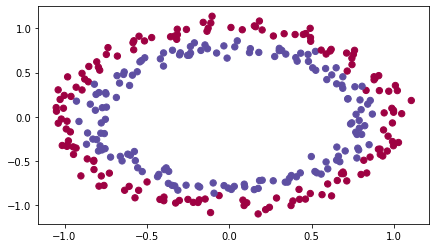

In [7]:
train_X, train_Y, test_X, test_Y = load_dataset(train_noise = .05, test_noise = .05)

In [13]:
# UNITEST
my_NN = DeepNeuralNetwork()
my_NN.infer_input_layer(train_X)
my_NN.add_hidden_layer(16, 'relu')
my_NN.add_hidden_layer(16, 'relu')
my_NN.add_hidden_layer(16, 'relu')
my_NN.add_hidden_layer(16, 'relu')
my_NN.add_output_layer(1, 'sigmoid')
costs = my_NN.fit(X=train_X, Y=train_Y, num_iterations=50000, print_cost=True)

Model - added input layer 		 Size = 2
Model - added hidden layer no: 1 	 Size = 16 	 Activation function = relu
Model - added hidden layer no: 2 	 Size = 16 	 Activation function = relu
Model - added hidden layer no: 3 	 Size = 16 	 Activation function = relu
Model - added hidden layer no: 4 	 Size = 16 	 Activation function = relu
Model - Added output layer 		 Size = 1 	 Activation function = sigmoid
Cost after iteration 0: 0.7373600253407522
Cost after iteration 2500: 0.2584485894730237
Cost after iteration 5000: 0.03731366258245904
Cost after iteration 7500: 0.02129559915983673
Cost after iteration 10000: 0.0145787926003769
Cost after iteration 12500: 0.011551793616225022
Cost after iteration 15000: 0.009579186935382589
Cost after iteration 17500: 0.008333213317573222
Cost after iteration 20000: 0.00736778104142199
Cost after iteration 22500: 0.006614307699169803
Cost after iteration 25000: 0.005967684215691046
Cost after iteration 27500: 0.005417185581175459
Cost after iteration 30

In [14]:
accuracy, _ = my_NN.test(X=test_X, Y=test_Y)
print(f"Cost = {costs[-1]} ]t Accuracy = {accuracy}")

Cost = 0.002689256424494676 ]t Accuracy = 0.96


<a name='2'></a>
## 2 - Loading the Dataset

<a name='3'></a>
## 3 - Exercise #1

At this point we don't have any indication of how a deep NN will work on this problem. Major parameters, such as the # of layers, and the size of each layer are not understood.
We will assume the NN has 3 hidden layers and we will try different layer sizes starting from 2 units per layer and growing as a factor of 2 until reaching 64.